In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import mlab
from scipy import signal
import h5py, time
import sys
import glob
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator


plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [2]:
# specify the folder
foldername = r'/home/data_transfer/data_from_windows/20201203/Bead2/Discharge/'

In [3]:
# load the files
files_discharge = load_dir(dirname=foldername, 
                         start_file=0, max_file=1500)

100%|██████████| 87/87 [02:22<00:00,  1.78s/it]

87  files in folder
87  files loaded


In [4]:
# set the drive and settings for the correlation
fdrive=71
nsamp = 50000
fsamp = 5000
sigamp = 1
tarr = np.arange(0, nsamp/fsamp, 1.0/fsamp)
sig = sigamp * np.sin(2.0 * np.pi * fdrive * tarr)


In [5]:
# get the in-phase response x
corrs = [correlation(drive=sig, response=files.x2, fsamp=fsamp, fdrive=fdrive, filt=True, band_width=1) for files in files_discharge]
indices = [np.argmax(cc) for cc in corrs]
in_phase = []
for cc in corrs:
    in_phase.append(cc[0])


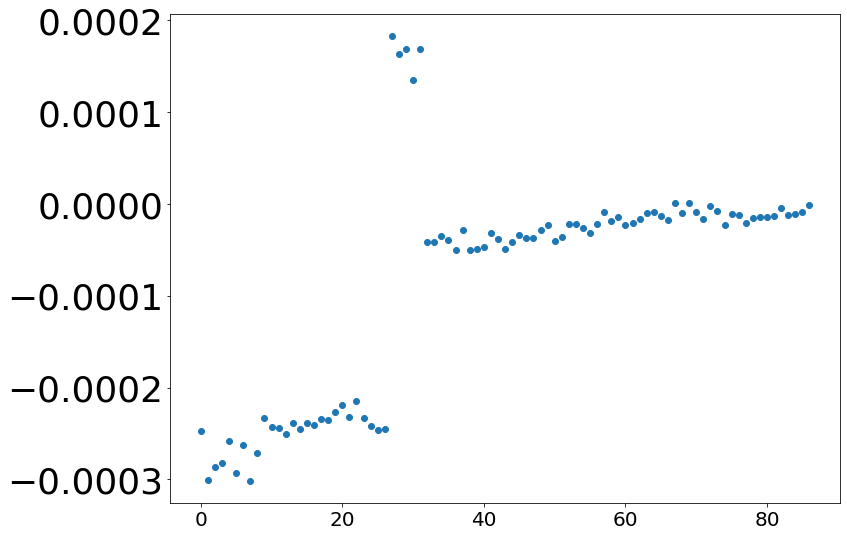

In [6]:
# plot the in-phase response
plt.plot(range(len(indices)),in_phase,linestyle="",marker="o")
#plt.ylim(-0.0001,0.00001)
plt.xlim()
plt.show()


In [7]:
# get the in-phase response y
corrs = [correlation(drive=sig, response=files.y2, fsamp=fsamp, fdrive=fdrive, filt=True, band_width=1) for files in files_discharge]
indices = [np.argmax(cc) for cc in corrs]
in_phase = []
for cc in corrs:
    in_phase.append(cc[0])



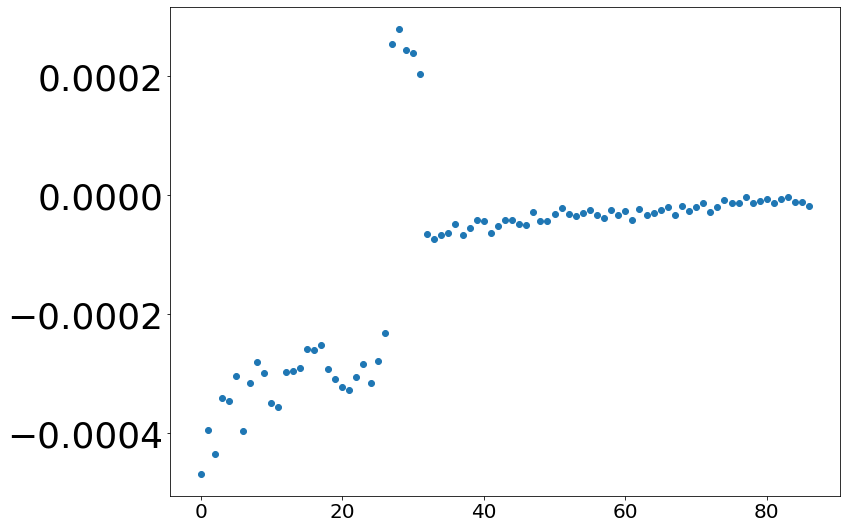

In [8]:
    
# plot the in-phase response
plt.plot(range(len(indices)),in_phase,linestyle="",marker="o")
plt.show()

In [9]:
# get the in-phase response z
corrs = [correlation(drive=sig, response=files.z2, fsamp=fsamp, fdrive=fdrive, filt=True, band_width=1) for files in files_discharge]
indices = [np.argmax(cc) for cc in corrs]
in_phase = []
for cc in corrs:
    in_phase.append(cc[0])



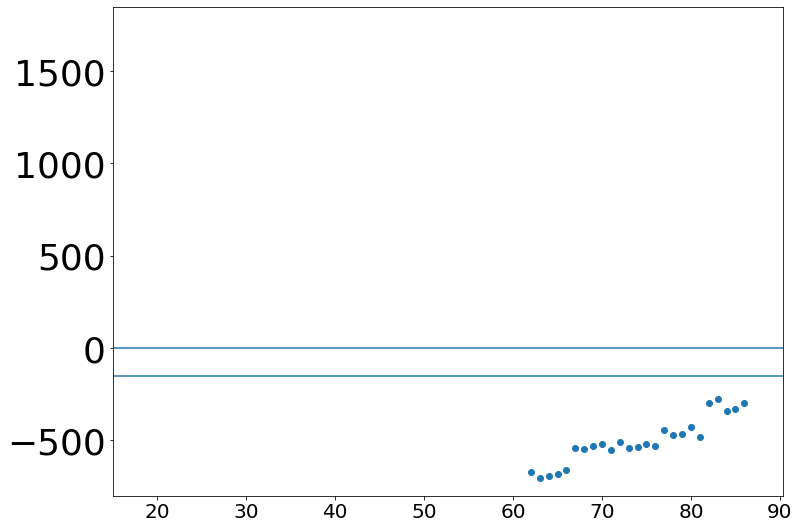

In [10]:
###### plot the in-phase response
plt.plot(range(len(indices)),in_phase,linestyle="",marker="o")
plt.ylim(-800,1850)
plt.xlim(15,)
#for i in np.arange(0,-1000,-74):
#    plt.axhline(i)
plt.axhline(0)
plt.axhline(-150)

plt.show()


In [ ]:
# load the response from the max_corr (basically)

resp_z = discharge_response(foldername=foldername,str_axis='z',drive_freq=71,max_file=1000)
#resp_x = discharge_response(foldername=foldername,str_axis='x',drive_freq=71,max_file=1000)
#resp_y = discharge_response(foldername=foldername,str_axis='y',drive_freq=71,max_file=1000)

  4%|▎         | 7/195 [00:03<01:39,  1.88it/s]

Error loading spinning data


  6%|▌         | 11/195 [00:05<01:27,  2.10it/s]

In [ ]:
# sum up everything in bins of 5 measurements
bin_cont_z, bin_cont_x, bin_cont_y = [ [] for x in range(3)]
bin_unc_z, bin_unc_x, bin_unc_y = [ [] for x in range(3)]
bin_corr, bin_cont_corr, bin_cont_corr = [ [] for x in range(3)]
bin_unc_corr, bin_unc_corr, bin_unc_corr = [ [] for x in range(3)]

bin_size = 5

for i in np.arange(0,len(resp_z),bin_size):
    bin_cont_z.append(np.mean(resp_z[i:i+bin_size]))
    bin_unc_z.append(np.std(resp_z[i:i+bin_size]))
    bin_corr.append(np.mean(in_phase[i:i+bin_size]))
    bin_unc_corr.append(np.std(in_phase[i:i+bin_size]))  


#for i in np.arange(0,len(resp_x),bin_size):
#    bin_cont_x.append(np.mean(resp_x[i:i+bin_size]))
#    bin_unc_x.append(np.std(resp_x[i:i+bin_size]))
#    bin_corr.append(np.mean(in_phase[i:i+bin_size]))
#    bin_unc_corr.append(np.std(in_phase[i:i+bin_size]))      
    

In [ ]:
# plot 5 bins with errors
plt.errorbar(range(len(bin_corr)),np.divide(bin_corr,350),np.divide(bin_unc_corr,75),linestyle="",marker="*",markersize=15)
#plt.errorbar(range(len(bin_cont_z)),np.divide(bin_cont_z,53),np.divide(bin_unc_z,55),linestyle="",marker="o")
#plt.xlim(0,15)#
plt.ylim(-20,2)
#plt.axhline(0)
for i in np.arange(0,-10,-1):
    plt.axhline(i,color="g")
#plt.ylim(-10000,0)

(0.0, 8.0)

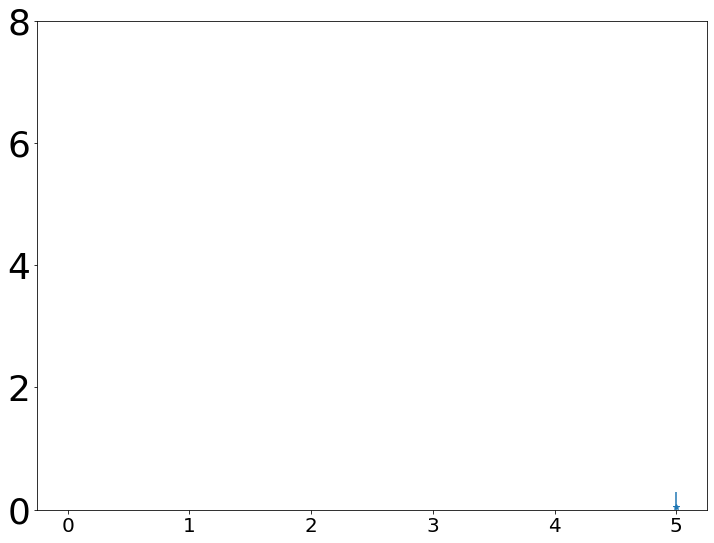

In [99]:
# plot 5 bins with errors
plt.errorbar(range(len(bin_corr)),np.divide(bin_corr,150.5),np.divide(bin_unc_corr,67.5),linestyle="",marker="*")
#plt.errorbar(range(len(bin_cont_z)),np.divide(bin_cont_z,53),np.divide(bin_unc_z,55),linestyle="",marker="o")
#plt.xlim(20,35)#
plt.ylim(-0,8)
#for i in np.arange(0,-10,-1):
#    plt.axhline(i,color="g")


In [100]:
len(bdf_list)

NameError: name 'bdf_list' is not defined

In [ ]:
files_discharge = load_dir(dirname=foldername, 
                         start_file=130, max_file=100)
bdf_list = files_discharge
fix_phase = False
drive_freq = 71
phase = 0
bandwidth = 1
decimate = 10

In [ ]:
la = likelihood_analyser.LikelihoodAnalyser()
fit_kwargs = {'A': 0, 'f': drive_freq, 'phi': phase,
    'error_A': 1, 'error_f': 1, 'error_phi': 0.5, 'errordef': 1,
    'limit_phi': [-np.pi, np.pi],
    'limit_A': [-10000, 10000],
    'print_level': 0, 'fix_f': True, 'fix_phi': fix_phase}

m1_list = []
for bb in bdf_list:
    frequency = fit_kwargs['f']
    xx2 = bb.response_at_freq2('x', frequency, bandwidth=bandwidth)
    xx2 = xx2[5000:-5000:decimate]  # cut out the first and last second

    m1_tmp = la.find_mle_sin(xx2, fsamp = 5000 / decimate, noise_rms=1, **fit_kwargs)
    m1_list.append(m1_tmp)
phases = np.array([m1_.values[2] for m1_ in m1_list])
amps = np.array([m1_.values[0] for m1_ in m1_list])

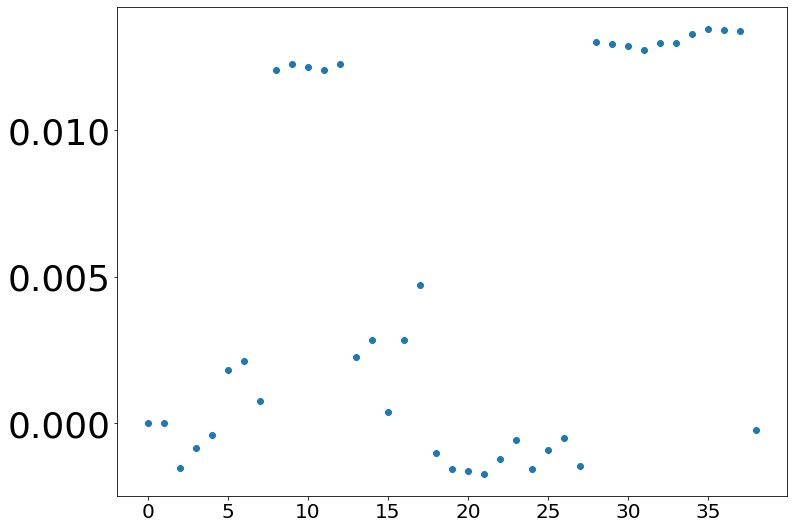

In [118]:
_,ax = plt.subplots()
ax.scatter(range(len(phases)), amps)